<a href="https://colab.research.google.com/github/fitzroypet/Detecting-Plant-Disease-using-MobileNet/blob/main/Combined_plant_disease_model_testing(BGImages).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocess Test Images

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Specify test dataset directory
test_dir = '/content/drive/MyDrive/Output_bg/test'

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(img_width,img_height),batch_size=batch_size)

Found 1906 images belonging to 10 classes.


In [5]:
# Get images and labels batch from validation dataset generator
import numpy as np

test_image_batch, test_label_batch = next(iter(test_generator))
true_label_ids = np.argmax(test_label_batch, axis=-1)

print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [6]:
# Generate dataset labels

dataset_labels = sorted(test_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Tomato___Bacterial_Spot' 'Tomato___Early_Blight' 'Tomato___Late_Blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_Leaf_Spot'
 'Tomato___Spider_Mites Two-Spotted_Spider_Mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_Mosaic_Virus'
 'Tomato___Healthy']


# Generate prediction for Model 2 (Tomato with BG)

In [7]:
import tensorflow as tf

# Specify model path
model2 = "/content/drive/MyDrive/model2-outputmobilenetof8epoch.tflite"

# Load the TFLite model (with background) and allocate tensors.
interpreter_2 = tf.lite.Interpreter(model_path=model2)

# Get input and output tensors.
input_details_2 = interpreter_2.get_input_details()
output_details_2 = interpreter_2.get_output_details()

print("== Input details (Bg) ==")
print("name:", input_details_2[0]['name'])
print("shape:", input_details_2[0]['shape'])
print("type:", input_details_2[0]['dtype'])

print("\n== Output details (Model2) ==")
print("name:", output_details_2[0]['name'])
print("shape:", output_details_2[0]['shape'])
print("type:", output_details_2[0]['dtype'])

== Input details (Bg) ==
name: serving_default_mobilenet_1.00_224_input:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details (Model2) ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.float32'>


Resize input and output tensors shapes
Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.

Let's resize input and output tensors, so we can make predictions for batch of 32 images.

In [8]:
# Resize model 2 (with bg)

interpreter_2.resize_tensor_input(input_details_2[0]['index'], (32, 224, 224, 3))
interpreter_2.resize_tensor_input(output_details_2[0]['index'], (32, 10))
interpreter_2.allocate_tensors()

input_details_2 = interpreter_2.get_input_details()
output_details_2 = interpreter_2.get_output_details()

print("== Input details (model 2) ==")
print("name:", input_details_2[0]['name'])
print("shape:", input_details_2[0]['shape'])
print("type:", input_details_2[0]['dtype'])

print("\n== Output details (model 2) ==")
print("name:", output_details_2[0]['name'])
print("shape:", output_details_2[0]['shape'])
print("type:", output_details_2[0]['dtype'])

== Input details (model 2) ==
name: serving_default_mobilenet_1.00_224_input:0
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details (model 2) ==
name: StatefulPartitionedCall:0
shape: [32 10]
type: <class 'numpy.float32'>


In [9]:
# Get model 2 predictions

interpreter_2.set_tensor(input_details_2[0]['index'], test_image_batch)
interpreter_2.invoke()

model2_predictions = interpreter_2.get_tensor(output_details_2[0]['index'])
print("Prediction results shape:", model2_predictions.shape)

Prediction results shape: (32, 10)


In [10]:
# Convert model 2 prediction results to Pandas dataframe, for better visualization

import pandas as pd
model2_pred_dataframe = pd.DataFrame(model2_predictions)
model2_pred_dataframe.columns = dataset_labels

print("Model 2 prediction results for the first elements")
model2_pred_dataframe.head()

Model 2 prediction results for the first elements


,Tomato___Bacterial_Spot,Tomato___Early_Blight,Tomato___Late_Blight,Tomato___Leaf_Mold,Tomato___Septoria_Leaf_Spot,Tomato___Spider_Mites Two-Spotted_Spider_Mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Mosaic_Virus,Tomato___Healthy
0,0.000333,0.137127,0.061134,0.000148,0.001748,2.495076e-05,6.025604e-02,0.000003,1.342548e-06,7.392251e-01
1,0.000003,0.001645,0.000185,0.000052,0.000034,5.808779e-06,1.558879e-05,0.998038,2.050533e-05,4.694522e-07
2,0.000124,0.000110,0.000032,0.000042,0.999687,1.327610e-07,5.630243e-08,0.000003,5.061216e-07,1.973418e-06
3,0.060219,0.010036,0.907104,0.000790,0.013026,5.353476e-03,2.406343e-03,0.000752,1.925009e-06,3.102050e-04
4,0.000175,0.402809,0.421986,0.031977,0.073982,7.024662e-05,6.739418e-02,0.000879,5.583404e-05,6.725391e-04


# Visualize Results for Model 2 (Tomato with BG)

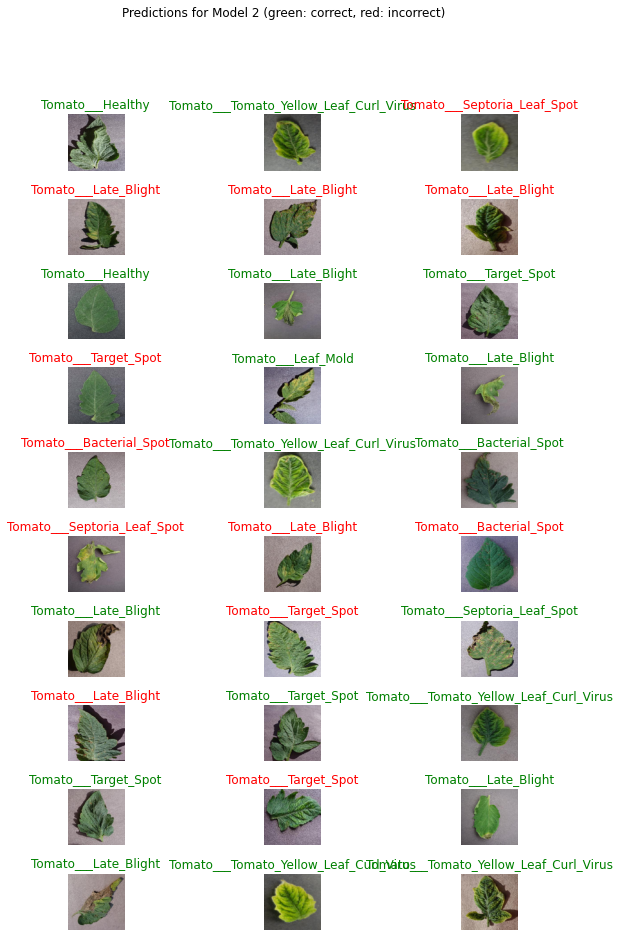

In [30]:
# Print images batch and labels predictions for model 2

import matplotlib.pyplot as plt

model2_predicted_ids = np.argmax(model2_predictions, axis=-1)
model2_predicted_labels = dataset_labels[model2_predicted_ids]
model2_label_id = np.argmax(test_label_batch, axis=-1)

plt.figure(figsize=(10,15))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(10,3,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if model2_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(model2_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Predictions for Model 2 (green: correct, red: incorrect)")

## Generate predictions for Model 3 (Tomato without BG)

In [12]:
# Specify model path for model without image background
model3 = "/content/drive/MyDrive/model3-outputmobilenetof8epoch.tflite"

# Load the TFLite model (no background) and allocate tensors.
interpreter_3 = tf.lite.Interpreter(model_path=model3)

# Get input and output tensors.
input_details_3 = interpreter_3.get_input_details()
output_details_3 = interpreter_3.get_output_details()

# Resize input and output tensors to handle batch of 32 images
interpreter_3.resize_tensor_input(input_details_3[0]['index'], (32, 224, 224, 3))
interpreter_3.resize_tensor_input(output_details_3[0]['index'], (32, 10))
interpreter_3.allocate_tensors()

print("== Input details (model3) ==")
print("name:", input_details_3[0]['name'])
print("shape:", input_details_3[0]['shape'])
print("type:", input_details_3[0]['dtype'])

print("\n== Output details (model3) ==")
print("name:", output_details_3[0]['name'])
print("shape:", output_details_3[0]['shape'])
print("type:", output_details_3[0]['dtype'])

== Input details (model3) ==
name: serving_default_mobilenet_1.00_224_input:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details (model3) ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.float32'>


In [13]:
# Run inference
interpreter_3.set_tensor(input_details_3[0]['index'], test_image_batch)

interpreter_3.invoke()

model3_predictions = interpreter_3.get_tensor(output_details_3[0]['index'])
print("\nPrediction results shape:", model3_predictions.shape)


Prediction results shape: (32, 10)


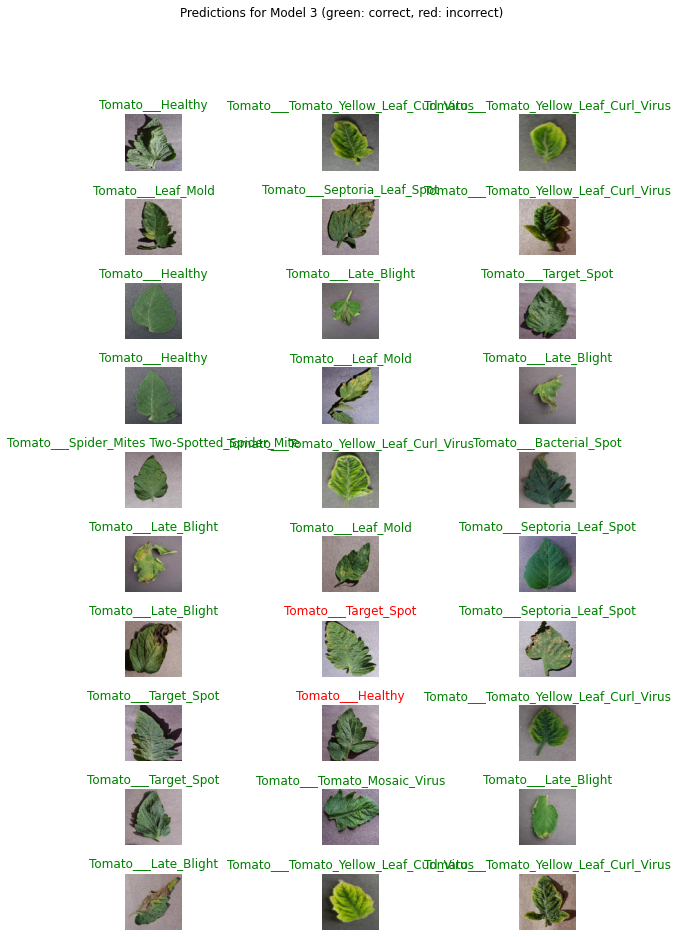

In [31]:
# Print images batch and labels predictions for Model 3

import matplotlib.pyplot as plt

model3_predicted_ids = np.argmax(model3_predictions, axis=-1)
model3_predicted_labels = dataset_labels[model3_predicted_ids]
model3_label_id = np.argmax(test_label_batch, axis=-1)

plt.figure(figsize=(10,15))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(10,3,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if model3_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(model3_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Predictions for Model 3 (green: correct, red: incorrect)")

In [15]:
# Convert Model 3 prediction results to Pandas dataframe, for better visualization

model3_pred_dataframe = pd.DataFrame(model3_predictions)
model3_pred_dataframe.columns = dataset_labels

print("Model 3 prediction results for the first elements")
model3_pred_dataframe.head()

Model 3 prediction results for the first elements


,Tomato___Bacterial_Spot,Tomato___Early_Blight,Tomato___Late_Blight,Tomato___Leaf_Mold,Tomato___Septoria_Leaf_Spot,Tomato___Spider_Mites Two-Spotted_Spider_Mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Mosaic_Virus,Tomato___Healthy
0,9.138216e-07,3.492540e-05,4.046599e-05,9.211803e-09,1.171124e-06,2.473222e-06,1.321648e-03,1.009804e-05,1.422031e-10,9.985883e-01
1,4.077806e-10,6.182282e-10,3.045799e-07,3.991688e-10,1.167429e-07,1.554921e-11,1.323929e-07,9.999247e-01,6.649042e-08,7.467052e-05
2,7.939765e-08,2.880511e-08,1.716545e-08,6.632906e-09,3.857421e-10,4.478286e-08,9.664435e-09,9.999998e-01,4.902866e-09,7.272186e-10
3,5.268625e-06,9.856206e-05,7.082104e-04,9.982798e-01,1.563078e-04,3.714183e-04,4.701413e-05,3.153775e-04,1.789395e-05,1.791543e-07
4,2.017285e-06,4.508009e-06,1.266525e-07,1.644957e-06,9.999906e-01,1.358459e-07,3.888406e-07,9.559485e-08,4.416873e-07,1.245502e-09


##Compare prediction results

Now we will use Pandas to visualize results from both models and find differences between them.

In [16]:
# Concatenate results from both models

all_models_dataframe = pd.concat([model2_pred_dataframe, 
                                  model3_pred_dataframe], 
                                 keys=['Model 2', 'Model 3'],
                                 axis='columns')
all_models_dataframe.head()

Model 2                                             \
  Tomato___Bacterial_Spot Tomato___Early_Blight Tomato___Late_Blight   
0                0.000333              0.137127             0.061134   
1                0.000003              0.001645             0.000185   
2                0.000124              0.000110             0.000032   
3                0.060219              0.010036             0.907104   
4                0.000175              0.402809             0.421986   

                                                  \
  Tomato___Leaf_Mold Tomato___Septoria_Leaf_Spot   
0           0.000148                    0.001748   
1           0.000052                    0.000034   
2           0.000042                    0.999687   
3           0.000790                    0.013026   
4           0.031977                    0.073982   

                                                                      \
  Tomato___Spider_Mites Two-Spotted_Spider_Mite Tomato___Target_Spot   
0                                  2.495076e-05         6.025604e-02   
1                                  5.808779e-06         1.558879e-05   
2                                  1.327610e-07         5.630243e-08   
3                                  5.353476e-03         2.406343e-03   
4                                  7.024662e-05         6.739418e-02   

                                                                       \
  Tomato___Tomato_Yellow_Leaf_Curl_Virus Tomato___Tomato_Mosaic_Virus   
0                               0.000003                 1.342548e-06   
1                               0.998038                 2.050533e-05   
2                               0.000003                 5.061216e-07   
3                               0.000752                 1.925009e-06   
4                               0.000879                 5.583404e-05   

                                   Model 3                        \
  Tomato___Healthy Tomato___Bacterial_Spot Tomato___Early_Blight   
0     7.392251e-01            9.138216e-07          3.492540e-05   
1     4.694522e-07            4.077806e-10          6.182282e-10   
2     1.973418e-06            7.939765e-08          2.880511e-08   
3     3.102050e-04            5.268625e-06          9.856206e-05   
4     6.725391e-04            2.017285e-06          4.508009e-06   

                                                                       \
  Tomato___Late_Blight Tomato___Leaf_Mold Tomato___Septoria_Leaf_Spot   
0         4.046599e-05       9.211803e-09                1.171124e-06   
1         3.045799e-07       3.991688e-10                1.167429e-07   
2         1.716545e-08       6.632906e-09                3.857421e-10   
3         7.082104e-04       9.982798e-01                1.563078e-04   
4         1.266525e-07       1.644957e-06                9.999906e-01   

                                                                      \
  Tomato___Spider_Mites Two-Spotted_Spider_Mite Tomato___Target_Spot   
0                                  2.473222e-06         1.321648e-03   
1                                  1.554921e-11         1.323929e-07   
2                                  4.478286e-08         9.664435e-09   
3                                  3.714183e-04         4.701413e-05   
4                                  1.358459e-07         3.888406e-07   

                                                                       \
  Tomato___Tomato_Yellow_Leaf_Curl_Virus Tomato___Tomato_Mosaic_Virus   
0                           1.009804e-05                 1.422031e-10   
1                           9.999247e-01                 6.649042e-08   
2                           9.999998e-01                 4.902866e-09   
3                           3.153775e-04                 1.789395e-05   
4                           9.559485e-08                 4.416873e-07   

                    
  Tomato___Healthy  
0     9.985883e-01  
1     7.467052e-05  
2     7.272186e-10  
3     1.791543e-07  

In [17]:
# Swap columns to have a side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[model2_pred_dataframe.columns]
all_models_dataframe.head()

Tomato___Bacterial_Spot               Tomato___Early_Blight                \
                  Model 2       Model 3               Model 2       Model 3   
0                0.000333  9.138216e-07              0.137127  3.492540e-05   
1                0.000003  4.077806e-10              0.001645  6.182282e-10   
2                0.000124  7.939765e-08              0.000110  2.880511e-08   
3                0.060219  5.268625e-06              0.010036  9.856206e-05   
4                0.000175  2.017285e-06              0.402809  4.508009e-06   

  Tomato___Late_Blight               Tomato___Leaf_Mold                \
               Model 2       Model 3            Model 2       Model 3   
0             0.061134  4.046599e-05           0.000148  9.211803e-09   
1             0.000185  3.045799e-07           0.000052  3.991688e-10   
2             0.000032  1.716545e-08           0.000042  6.632906e-09   
3             0.907104  7.082104e-04           0.000790  9.982798e-01   
4             0.421986  1.266525e-07           0.031977  1.644957e-06   

  Tomato___Septoria_Leaf_Spot                \
                      Model 2       Model 3   
0                    0.001748  1.171124e-06   
1                    0.000034  1.167429e-07   
2                    0.999687  3.857421e-10   
3                    0.013026  1.563078e-04   
4                    0.073982  9.999906e-01   

  Tomato___Spider_Mites Two-Spotted_Spider_Mite                \
                                        Model 2       Model 3   
0                                  2.495076e-05  2.473222e-06   
1                                  5.808779e-06  1.554921e-11   
2                                  1.327610e-07  4.478286e-08   
3                                  5.353476e-03  3.714183e-04   
4                                  7.024662e-05  1.358459e-07   

  Tomato___Target_Spot               Tomato___Tomato_Yellow_Leaf_Curl_Virus  \
               Model 2       Model 3                                Model 2   
0         6.025604e-02  1.321648e-03                               0.000003   
1         1.558879e-05  1.323929e-07                               0.998038   
2         5.630243e-08  9.664435e-09                               0.000003   
3         2.406343e-03  4.701413e-05                               0.000752   
4         6.739418e-02  3.888406e-07                               0.000879   

                Tomato___Tomato_Mosaic_Virus               Tomato___Healthy  \
        Model 3                      Model 2       Model 3          Model 2   
0  1.009804e-05                 1.342548e-06  1.422031e-10     7.392251e-01   
1  9.999247e-01                 2.050533e-05  6.649042e-08     4.694522e-07   
2  9.999998e-01                 5.061216e-07  4.902866e-09     1.973418e-06   
3  3.153775e-04                 1.925009e-06  1.789395e-05     3.102050e-04   
4  9.559485e-08                 5.583404e-05  4.416873e-07     6.725391e-04   

                 
        Model 3  
0  9.985883e-01  
1  7.467052e-05  
2  7.272186e-10  
3  1.791543e-07  
4  1.245502e-09

In [18]:
# Highlight model 3 predictions that are different from model 2

def highlight_diff(data, color='grey'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('Model 2', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

As we can see, in most cases predictions are different between all models, usually by small factors. High-confidence predictions between TensorFlow and TensorFlow Lite models are very close to each other (in some cases there are even similar).
Quantized model outstands the most, but this is the cost of optimizations (model weights 3-4 times less).

To make prediction results even more readable, let's simplify dataframes, to show only the highest-score prediction and the corresponding label.

In [19]:
# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
model2_pred_simplified = max_values_only(model2_predictions)
model3_pred_simplified = max_values_only(model3_predictions)

In [20]:
# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
model2_simple_dataframe = pd.DataFrame(model2_pred_simplified)
model2_simple_dataframe.columns = columns_names

model3_simple_dataframe = pd.DataFrame(model3_pred_simplified)
model3_simple_dataframe.columns = columns_names

model2_simple_dataframe.head()
model3_simple_dataframe.head()

,Label_id,Confidence
0,9.0,0.998588
1,7.0,0.999925
2,7.0,1.000000
3,3.0,0.998280
4,4.0,0.999991


In [21]:
# Concatenate results from all models
all_models_simple_dataframe = pd.concat([model2_simple_dataframe,
                                         model3_simple_dataframe], 
                                        keys=['Model 2', 'Model 3'],
                                        axis='columns')

# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[model2_simple_dataframe.columns]

# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)